GRID SIZE:  32
Data shape: (1000, 2)
[[0.         2.71213211 2.59563926 ... 2.60488795 0.63249972 3.13851077]
 [2.71213211 0.         0.63901434 ... 2.50514732 2.89902198 3.47108215]
 [2.59563926 0.63901434 0.         ... 1.88806756 2.91528799 2.85288259]
 ...
 [2.60488795 2.50514732 1.88806756 ... 0.         3.19692937 0.96601409]
 [0.63249972 2.89902198 2.91528799 ... 3.19692937 0.         3.76737337]
 [3.13851077 3.47108215 2.85288259 ... 0.96601409 3.76737337 0.        ]]
entering try
 IS this working???


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


Eigenvalues shape: (1000,)
Eigenvectors shape: (1000, 1000)
sucessfully
entered lund
Number of Eigenvalues: 1000
Number of Eigenvectors: (1000, 1000)
replicate error
DiffusionMap shape:  1000
Diffusion map after the loop: [[ 1.00000000e+00  6.32805388e-03 -1.35051390e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -5.24400731e-03 -1.68811060e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -3.84670896e-03 -1.95650503e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.00000000e+00 -8.16455674e-04  2.14475330e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  6.72541147e-03 -1.61948291e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -8.39809671e-04  2.42433169e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Number of clusters: 1
Aligned Accuracy: 0.501


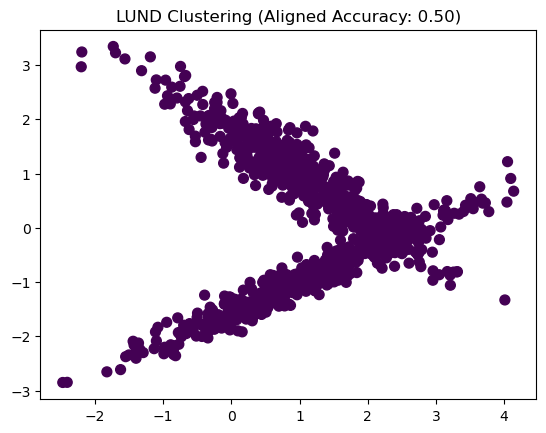

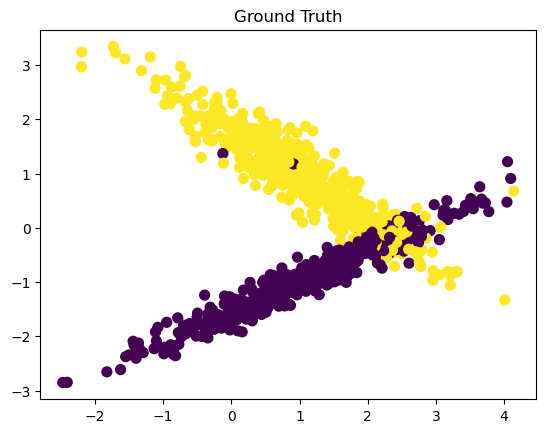

In [2]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import make_moons, make_blobs, make_classification

from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor,KDE
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
# print(X.shape)
# X, GT = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
X, GT = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
scipy.io.savemat('data.mat', {'X': X, 'GT': GT})

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
Hyperparameters = {
    'Sigma': 1.0,
    'DiffusionNN': 10,
    'SpatialParams': {
        'GraphSpatialRadius': 12,
        'ConsensusSpatialRadius': 1,
        'ImageSize': (grid_size, grid_size)
    }
}

density_estimator = KDE()
graph_extractor = GraphExtractor()


p = density_estimator.kde(X)
G = graph_extractor.extract_graph(X)

t = 43

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, t, G, p)



# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)
# print("Diffusion distances:", Dt)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    

plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from lund.utils import DensityEstimator


# Generate synthetic data
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=1.0, random_state=42)

density_estimator = DensityEstimator(DensityNN=5, Sigma0=1.0)
p_custom = density_estimator.kde(X)

# using sklearn as comparison
kde_sklearn = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(X)
log_density = kde_sklearn.score_samples(X)
p_sklearn = np.exp(log_density)

p_custom /= np.sum(p_custom)
p_sklearn /= np.sum(p_sklearn)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sc1 = ax[0].scatter(X[:, 0], X[:, 1], c=p_custom, cmap='viridis')
ax[0].set_title('Density Estimation with Custom KDE')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
fig.colorbar(sc1, ax=ax[0], label='Density')

sc2 = ax[1].scatter(X[:, 0], X[:, 1], c=p_sklearn, cmap='viridis')
ax[1].set_title('Density Estimation with scikit-learn KDE')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
fig.colorbar(sc2, ax=ax[1], label='Density')

plt.show()